### Data Functions

In [11]:

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image

In [13]:

def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


In [14]:

def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

### Modelling

In [ ]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd

In [9]:
# X_test, y_test=read_hoda_cdb('Test 20000.cdb')
# X_train, y_train=read_hoda_cdb('Train 60000.cdb')

In [ ]:
xf, yf = read_hoda_dataset(dataset_path='Train 60000.cdb',
                                images_height=28,
                                images_width=28,
                                one_hot=False,
                                reshape=True)
X_test, y_test = read_hoda_dataset(dataset_path='Test 20000.cdb',
                                images_height=28,
                                images_width=28,
                                one_hot=False,
                                reshape=True)
X_train, y_train=xf[:40000] , yf[:40000]
X_valid, y_valid = xf[40000:] , yf[40000:]


In [17]:
a=X_train[1]
b=a.reshape(28,28)

In [18]:
b.shape

(28, 28)

In [19]:
tf.random.set_seed(42)
model = keras.Sequential()
model.add(keras.layers.Input(shape=[784]))
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2023-02-17 14:20:38.910207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-17 14:20:38.910277: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-17 14:20:38.910320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e20175251072): /proc/driver/nvidia/version does not exist


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
metrics=["accuracy"])

In [71]:
history = model.fit(X_train, y_train, epochs=4 ,validation_data=(X_valid, y_valid))

Epoch 1/4
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0171 - accuracy: 0.9953 - val_loss: 0.0453 - val_accuracy: 0.9865
Epoch 2/4
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.0488 - val_accuracy: 0.9870
Epoch 3/4
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0070 - accuracy: 0.9986 - val_loss: 0.0463 - val_accuracy: 0.9873
Epoch 4/4
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0042 - accuracy: 0.9994 - val_loss: 0.0476 - val_accuracy: 0.9865


In [72]:
history

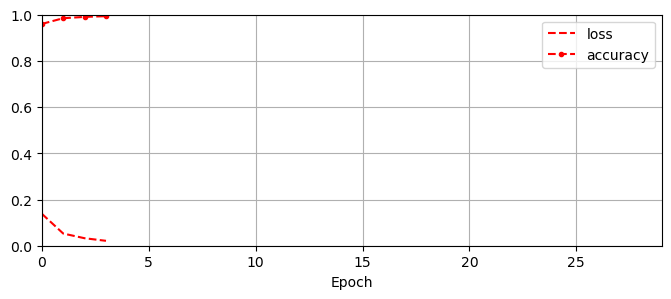

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(
figsize=(8, 3), xlim=[0, 29], ylim=[0, 1], grid=True,
xlabel="Epoch",
style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [98]:
model.evaluate(X_test, y_test)

625/625 [==============================] - 2s 3ms/step - loss: 0.0850 - accuracy: 0.9743


[0.0849677175283432, 0.9743000268936157]

### model predict

In [ ]:
y_proba = model.predict(X_new)
y_proba.round(2)
import numpy as np
y_pred = y_proba.argmax(axis=-1)

### Functional

In [45]:
tf.random.set_seed(42)

normalization_layer = keras.layers.Normalization()
hidden_layer1 = keras.layers.Dense(50, activation="relu")
hidden_layer2 = keras.layers.Dense(40, activation="relu")
concat_layer = keras.layers.Concatenate()
output_layer = keras.layers.Dense(10, activation="softmax")

input_ = keras.layers.Input(shape=[784])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
# concat = concat_layer([normalized, hidden2])
concat = concat_layer([hidden2])

output = output_layer(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [46]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
# model.compile(loss="mse", optimizer=optimizer, metrics=
# ["RootMeanSquaredError" , 'accuracy'])

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer=keras.optimizers.SGD(learning_rate=0.1),
metrics=["RootMeanSquaredError" ,"accuracy"])


In [44]:
history = model.fit(X_train, y_train, epochs=3)


Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1739 - root_mean_squared_error: 5.2622 - accuracy: 0.9502
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0744 - root_mean_squared_error: 5.2627 - accuracy: 0.9782
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0522 - root_mean_squared_error: 5.2628 - accuracy: 0.9841


### Final Test with another pic

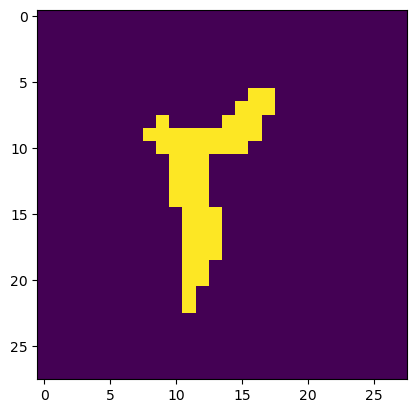

In [68]:

import matplotlib.pyplot as plt
import cv2

# img = cv2.imread('2.jpg',cv2.IMREAD_GRAYSCALE)
# imr = cv2.resize(img, (28, 28), interpolation = cv2.INTER_LINEAR)


img = cv2.imread('2.jpg',cv2.IMREAD_GRAYSCALE)
imr = cv2.resize(img, (28, 28), interpolation = cv2.INTER_LINEAR)
imr=(abs((imr/254)-1)).round(0)
test=imr.reshape(-1, 1).T
plt.figure()
plt.imshow(imr) 
plt.show()  # display it

مدل به دست آمده با احتمال ۵۵ درصد عدد دو را پیش بینی کرد:

In [69]:
model.predict(test)

1/1 [==============================] - 0s 64ms/step


array([[0.07948565, 0.05588472, 0.55862164, 0.06001833, 0.19652593,
        0.00365272, 0.01673608, 0.02295334, 0.00398049, 0.00214114]],
      dtype=float32)